import sys
!{sys.executable} -m pip install music21
!{sys.executable} -m pip install tqdm



## Methodology:

We write functions to:

1- Encode Each song.

2- Decode each song and save it as midi.

3- Obtain a dict that translates each event into a numerical value.

4- Prepare input sequences and outputs for the three LSTMs to be trained.

5- Train the LSTMs.

6- Use the three trained LSTMs to generate music.

In [1]:
import music21
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pandas as pd
from keras.utils import np_utils
from collections import defaultdict

from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten


C:\Users\MHarajli\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def encode_song(filename):
    """Encodes song in filename. See milestone1 report for encoding"""
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes
        
    pitches=[]
    offsets=[]
        
    for note in notesRaw:
        if isinstance(note,music21.note.Note):
            pitches.append(note.pitch.midi)
            offsets.append(note.offset)
        else:
            chordNotes=[int(b.midi) for b in note.pitches]
            pitches.extend(chordNotes)
            offsets.extend([note.offset]*len(chordNotes))

    pitches=np.array(pitches)
    offsets=np.array(offsets)
    uniqueSortedOffsets=np.sort(np.unique(offsets))
    
    encoding=[]
    
    for i in range(len(uniqueSortedOffsets)-1):
        time=uniqueSortedOffsets[i]
        pitchesHere=pitches[offsets==time]
        goforward='gf'+str(uniqueSortedOffsets[i+1]-time)
        
        encoding.extend(list(np.sort(pitchesHere)))
        encoding.append(goforward)
        
        
    
    return encoding   

In [3]:
def decode_song(song,filename):
    """Decodes song encoded by encode_song(). song is an encoded song of type list, and filename is
    the path where the new decoded midi file is to reside"""
    stream=[]
    offset=0
    for event in song:
        if 'gf' in str(event):
            offset+=float(event[2:])
        else:
            newNote=music21.note.Note(int(event))
            newNote.offset=offset
            newNote.storedInstrument=music21.instrument.Piano()
            stream.append(newNote)
    midi_stream=music21.stream.Stream(stream)
    midi_stream.write('midi', fp=filename)
    return 1
    
    
    

In [4]:
#we get the the directories of all the songs in our dataset. 

artists=glob.glob('Music/*') #files are sorted via artist
 
songs=[] #the song filename

for artist in artists:
    songs.extend(glob.glob(artist+'/*'))


In [26]:
#we encode each song, save them in a dataframe, and then pickle the dataframe.
information=defaultdict(list)

for song in tqdm(songs):
    encoded=encode_song(song)
    _,artist,songname=song.split('\\')
    information['SongName'].append(songname)
    information['Artist'].append(artist)
    information['Encoded'].append(encoded)
    



100%|████████████████████████████████████████| 266/266 [28:20<00:00,  2.48s/it]


In [28]:
DF_to_save=pd.DataFrame.from_dict(information)
DF_to_save.head()

with open('encodings/information.pickle','wb') as file:
    pickle.dump(DF_to_save,file)

In [30]:
DF=DF_to_save
DF_to_save=[]

In [41]:
#inWhat follows we create three dictionaries: one for notes and gf (which will be used in the input)
#another for just gfs (output of get_gf), and another for just notes (for get_note)

#we first get all the unique elements of our vocabulary:

vocab=[]
for i in tqdm(range(len(DF))):
    vocab.extend(DF.iloc[i,2])
    vocab=list(set(vocab))
    
notesOnly=[]
gfOnly=[]

for word in vocab:

    if 'gf' in str(word):
        gfOnly.append(word)
    else:
        notesOnly.append(word)

100%|██████████████████████████████████████| 266/266 [00:00<00:00, 3410.24it/s]


In [49]:
#we check to see what is the quarter lengths duration of the unique go forward events
numbers=[]
for gf in gfOnly:
    if '/' in gf:
        num,denom=gf.split('/')
        num=num[2:]
        numbers.append(float(num)/float(denom))
    else:
        numbers.append(float(gf[2:]))

In [52]:
print(sorted(numbers))

[0.08333333333325754, 0.08333333333331439, 0.0833333333333286, 0.08333333333333215, 0.08333333333333304, 0.08333333333333326, 0.08333333333333331, 0.08333333333333337, 0.08333333333333348, 0.08333333333333393, 0.0833333333333357, 0.08333333333334281, 0.08333333333337123, 0.16666666666662877, 0.1666666666666572, 0.1666666666666643, 0.16666666666666607, 0.16666666666666652, 0.16666666666666663, 0.16666666666666669, 0.16666666666666674, 0.16666666666666696, 0.16666666666666785, 0.1666666666666714, 0.16666666666668561, 0.16666666666674246, 0.25, 0.33333333333325754, 0.3333333333333144, 0.3333333333333286, 0.33333333333333215, 0.33333333333333304, 0.33333333333333326, 0.3333333333333333, 0.3333333333333333, 0.33333333333333337, 0.3333333333333335, 0.3333333333333339, 0.3333333333333357, 0.3333333333333428, 0.33333333333337123, 0.41666666666662877, 0.4166666666666572, 0.4166666666666643, 0.41666666666666663, 0.41666666666666785, 0.4166666666666714, 0.4166666666666856, 0.5, 0.6666666666666288

From above we see that alot of the unique offsets are essentially the same but differ slightly due to representation by the author of the midi file. We thus have to fix something in the representation of the gfs. This is something we could have fixed in the encode_song function. However to avoid having to open the files again, we ammend the issue in the dataframe.

In [55]:
np.round(1,4)

1

In [84]:
NewColumn=[]
for i in tqdm(range(len(DF))):
    encoding=DF.iloc[i,2]
    #now loop through every word of the encoding
    replacement=[]
    for i,word in enumerate(encoding):
        if 'gf' in str(word):
            #we have a gf, we isolate the word from the letters 'gf'
            keep=word[2:]
            #we now check to see if there is a division symbol:
            if '/' in keep:
                numerator,denominator=keep.split('/')
                keep=np.round(float(numerator)/float(denominator),4)
                replacement.append('gf'+str(keep))
            else:
                replacement.append('gf'+str(np.round(float(keep),4)))
                
        else:
            #its just a note.
            replacement.append(word)
    NewColumn.append(replacement)

100%|████████████████████████████████████████| 266/266 [00:03<00:00, 76.09it/s]


In [87]:
DF['ModedEncoded']=NewColumn


In [ ]:
DF=DF.drop(columns='Encoded')

In [95]:
with open('encodings/information.pickle','wb') as file:
    pickle.dump(DF,file)

In [162]:
with open('encodings/information.pickle','rb') as file:
    DF=pickle.load(file)

In [163]:
DF.head()

,SongName,Artist,ModedEncoded
0,alb_esp1.mid,albeniz,"[57, 81, gf0.5, 64, 88, gf3.25, 62, 86, gf0.08..."
1,alb_esp2.mid,albeniz,"[38, 50, gf0.75, 57, gf0.25, 62, 66, 69, gf0.5..."
2,alb_esp3.mid,albeniz,"[59, 71, gf0.5, 63, 75, gf0.5, 66, 78, gf0.5, ..."
3,alb_esp4.mid,albeniz,"[79, gf0.5, 71, 74, gf0.5, 72, 75, gf0.5, 69, ..."
4,alb_esp5.mid,albeniz,"[51, 58, gf0.5, 58, gf1.0, 58, gf0.5, 51, 58, ..."


In [184]:
DF=DF[DF['Artist']=='chopin']

In [185]:
DF=DF.iloc[[0,1],:]

In [186]:
#we first get all the unique elements of our vocabulary:

vocab=[]
for i in tqdm(range(len(DF))):
    vocab.extend(DF.iloc[i,2])
    vocab=list(set(vocab))
    
notesOnly=[]
gfOnly=[]

for word in vocab:

    if 'gf' in str(word):
        gfOnly.append(word)
    else:
        notesOnly.append(word)

100%|████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [187]:
len(vocab)

66

In [12]:
#we check to see what is the quarter lengths duration of the unique go forward events
numbers=[]
for gf in gfOnly:
    if '/' in gf:
        num,denom=gf.split('/')
        num=num[2:]
        numbers.append(float(num)/float(denom))
    else:
        numbers.append(float(gf[2:]))
sorted(numbers)

[0.0833, 0.1667, 0.25]

In [ ]:
#we now can start preparing inputs and outputs for the various neural networks we want to train.

In [188]:
#first step is getting a representation of the vocabulary:
vocab=[]
for i in tqdm(range(len(DF))):
    vocab.extend(DF.iloc[i,2])
    vocab=list(set(vocab))

100%|████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [189]:
#we create a dict to translate each vocab element to a number and vice versa:
WordToNumber={}
NumberToWord={}

GfToNumber={}
NumberToGf={}

NoteToNumber={}
NumberToNote={}


gf_index=0
note_index=0

for i,word in enumerate(vocab):
    WordToNumber[word]=i
    NumberToWord[i]=word
    if 'gf' in str(word):
        GfToNumber[word]=gf_index
        NumberToGf[gf_index]=word
        gf_index+=1
    else:
        NoteToNumber[word]=note_index
        NumberToNote[note_index]=word
        note_index+=1




## LSTM Architecture:

We have 3 neural networks:

1- gf_or_note

2- get_gf

3- get_note



The inputs for all three of the nets are in the same space and have the same representation. The outputs differ. The output of gf_or_note is binary, the output of get_gf is limited to the different available gf's while the output of get_note is limited to the keys on the piano.

We begin by getting a string

In [190]:
def prepare_sequences_gf_or_note(DF, n_vocab,WordToNumber,sequence_length=100): 
    """Given a list of locations for all the midi files in the dataset, this function encodes each song"""
    # Extract the unique pitches in the list of notes.

    network_input = []
    network_output = []
    for i in tqdm(range(len(DF))):
        song=DF.iloc[i,2]
        # create input sequences and the corresponding outputs
        
        for i in range(0, len(song) - sequence_length, 1):
            #we only use the sequence if the last event is not a gf event:
            sequence_in = song[i: i + sequence_length]
            if 'gf' not in str(sequence_in[-1]):
                sequence_out = float('gf' in str(song[i + sequence_length]))
                network_input.append([WordToNumber[char] for char in sequence_in])
                network_output.append(sequence_out)
                

    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

In [191]:
inp,out=prepare_sequences_gf_or_note(DF,len(WordToNumber),WordToNumber)
print(inp.shape)
print(out.shape)

100%|████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


(521, 100, 1)
(521, 2)


In [192]:
def prepare_sequences_get_gf(DF, n_vocab,WordToNumber,GfToNumber,sequence_length=100): 
    """Given a list of locations for all the midi files in the dataset, this function encodes each song"""
    # Extract the unique pitches in the list of notes.

    network_input = []
    network_output = []
    for i in tqdm(range(len(DF))):
        song=DF.iloc[i,2]
        # create input sequences and the corresponding outputs
        
        for i in range(0, len(song) - sequence_length, 1):
            #we only use the sequence if the last event is not a gf event:
            sequence_in = song[i: i + sequence_length]
            sequence_out=song[i + sequence_length]
            if 'gf' in str(sequence_out):
                network_input.append([WordToNumber[char] for char in sequence_in])
                network_output.append(GfToNumber[sequence_out])
                

    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

In [193]:
inp,out=prepare_sequences_get_gf(DF,len(WordToNumber),WordToNumber,GfToNumber)
print(inp.shape)
print(out.shape)

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 128.20it/s]


(290, 100, 1)
(290, 6)


In [194]:
def prepare_sequences_get_note(DF, n_vocab,WordToNumber,NoteToNumber,sequence_length=100): 
    """Given a list of locations for all the midi files in the dataset, this function encodes each song"""
    # Extract the unique pitches in the list of notes.

    network_input = []
    network_output = []
    for i in tqdm(range(len(DF))):
        song=DF.iloc[i,2]
        # create input sequences and the corresponding outputs
        
        for i in range(0, len(song) - sequence_length, 1):
            #we only use the sequence if the last event is not a gf event:
            sequence_in = song[i: i + sequence_length]
            sequence_out=song[i + sequence_length]
            if 'gf' not in str(sequence_out):
                network_input.append([WordToNumber[char] for char in sequence_in])
                network_output.append(NoteToNumber[sequence_out])
                

    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output)
    
    return (network_input, network_output)

In [195]:
inp,out=prepare_sequences_get_note(DF,len(WordToNumber),WordToNumber,NoteToNumber)
print(inp.shape)
print(out.shape)

100%|████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


(519, 100, 1)
(519, 60)


In [225]:
def create_network_gf_or_note(network_in, n_vocab_out): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(20, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20,return_sequences=True))
    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab_out))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [226]:
def create_network_get_gf(network_in, n_vocab_out): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(20, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20,return_sequences=True))
    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab_out))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [227]:
def create_network_get_note(network_in, n_vocab_out): 
    """Create the model architecture"""
    model = Sequential()
    model.add(LSTM(20, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20,return_sequences=True))
    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab_out))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [228]:
from keras.callbacks import ModelCheckpoint
def train_gf_or_note(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'SavedModels/weights.gf_or_note.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=10000, callbacks=[checkpoint])

In [229]:
def train_get_gf(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'SavedModels/weights.get_gf.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=10000, callbacks=[checkpoint])

In [230]:
def train_get_note(model, network_input, network_output, epochs): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'SavedModels/weights.get_note.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=10000, callbacks=[checkpoint])

In [231]:
epochs=500

gf_or_note_input,gf_or_note_output=prepare_sequences_gf_or_note(DF,len(WordToNumber),WordToNumber)
get_gf_input,get_gf_output=prepare_sequences_get_gf(DF,len(WordToNumber),WordToNumber,GfToNumber)
get_note_input,get_note_output=prepare_sequences_get_note(DF,len(WordToNumber),WordToNumber,NoteToNumber)

print('Sequences Prepared, creating models')

gf_or_note=create_network_gf_or_note(gf_or_note_input,gf_or_note_output.shape[1])
get_gf=create_network_get_gf(get_gf_input,get_gf_output.shape[1])
get_note=create_network_get_note(get_note_input,get_note_output.shape[1])

print('Models Created, training in progress')

train_gf_or_note(gf_or_note,gf_or_note_input,gf_or_note_output,epochs)
#train_get_gf(get_gf,get_gf_input,get_gf_output,epochs)
#train_get_note(get_note,get_note_input,get_note_output,epochs)

print('Training completed')

100%|████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


Sequences Prepared, creating models
Models Created, training in progress
Epoch 1/500
521/521 [==============================] - 4s 9ms/step - loss: 0.6979 - acc: 0.4760
Epoch 2/500
521/521 [==============================] - 0s 837us/step - loss: 0.6894 - acc: 0.5566
Epoch 3/500
521/521 [==============================] - 0s 878us/step - loss: 0.6908 - acc: 0.5566
Epoch 4/500
521/521 [==============================] - 0s 907us/step - loss: 0.6863 - acc: 0.5566
Epoch 5/500
521/521 [==============================] - 0s 887us/step - loss: 0.6861 - acc: 0.5547
Epoch 6/500
521/521 [==============================] - 1s 1ms/step - loss: 0.6861 - acc: 0.5547
Epoch 7/500
521/521 [==============================] - 0s 936us/step - loss: 0.6871 - acc: 0.5643
Epoch 8/500
521/521 [==============================] - 0s 924us/step - loss: 0.6869 - acc: 0.5643
Epoch 9/500
521/521 [==============================] - 0s 918us/step - loss: 0.6846 - acc: 0.5681
Epoch 10/500
521/521 [===========================

521/521 [==============================] - 0s 907us/step - loss: 0.5757 - acc: 0.6814
Epoch 84/500
521/521 [==============================] - 0s 902us/step - loss: 0.5806 - acc: 0.7083
Epoch 85/500
521/521 [==============================] - 0s 907us/step - loss: 0.5690 - acc: 0.7466
Epoch 86/500
521/521 [==============================] - 1s 965us/step - loss: 0.5854 - acc: 0.7044
Epoch 87/500
521/521 [==============================] - 0s 912us/step - loss: 0.5679 - acc: 0.7063
Epoch 88/500
521/521 [==============================] - 0s 912us/step - loss: 0.5626 - acc: 0.6967
Epoch 89/500
521/521 [==============================] - 0s 897us/step - loss: 0.5596 - acc: 0.7159
Epoch 90/500
521/521 [==============================] - 0s 902us/step - loss: 0.5581 - acc: 0.7409
Epoch 91/500
521/521 [==============================] - 1s 993us/step - loss: 0.5656 - acc: 0.7543
Epoch 92/500
521/521 [==============================] - 0s 955us/step - loss: 0.5591 - acc: 0.7179
Epoch 93/500
521/521 [=

521/521 [==============================] - 0s 926us/step - loss: 0.3307 - acc: 0.8656
Epoch 166/500
521/521 [==============================] - 0s 902us/step - loss: 0.3266 - acc: 0.8695
Epoch 167/500
521/521 [==============================] - 0s 907us/step - loss: 0.3206 - acc: 0.8695
Epoch 168/500
521/521 [==============================] - 0s 907us/step - loss: 0.3306 - acc: 0.8695
Epoch 169/500
521/521 [==============================] - 0s 902us/step - loss: 0.3313 - acc: 0.8580
Epoch 170/500
521/521 [==============================] - 0s 893us/step - loss: 0.3233 - acc: 0.8637
Epoch 171/500
521/521 [==============================] - 0s 941us/step - loss: 0.3268 - acc: 0.8714
Epoch 172/500
521/521 [==============================] - 0s 902us/step - loss: 0.3278 - acc: 0.8580
Epoch 173/500
521/521 [==============================] - 0s 902us/step - loss: 0.3219 - acc: 0.8560
Epoch 174/500
521/521 [==============================] - 0s 917us/step - loss: 0.3277 - acc: 0.8695
Epoch 175/500


Epoch 247/500
521/521 [==============================] - 0s 883us/step - loss: 0.2673 - acc: 0.8848
Epoch 248/500
521/521 [==============================] - 0s 917us/step - loss: 0.2793 - acc: 0.8829
Epoch 249/500
521/521 [==============================] - 0s 921us/step - loss: 0.2700 - acc: 0.8676
Epoch 250/500
521/521 [==============================] - 0s 893us/step - loss: 0.2851 - acc: 0.8791
Epoch 251/500
521/521 [==============================] - 0s 945us/step - loss: 0.2576 - acc: 0.9079
Epoch 252/500
521/521 [==============================] - 0s 897us/step - loss: 0.2553 - acc: 0.8983
Epoch 253/500
521/521 [==============================] - 0s 912us/step - loss: 0.2676 - acc: 0.8887
Epoch 254/500
521/521 [==============================] - 0s 926us/step - loss: 0.2548 - acc: 0.8906
Epoch 255/500
521/521 [==============================] - 0s 907us/step - loss: 0.2653 - acc: 0.8925
Epoch 256/500
521/521 [==============================] - 0s 912us/step - loss: 0.2502 - acc: 0.8925


Epoch 329/500
521/521 [==============================] - 0s 835us/step - loss: 0.2166 - acc: 0.9079
Epoch 330/500
521/521 [==============================] - 0s 916us/step - loss: 0.2283 - acc: 0.9021
Epoch 331/500
521/521 [==============================] - 0s 818us/step - loss: 0.2238 - acc: 0.9040
Epoch 332/500
521/521 [==============================] - 0s 830us/step - loss: 0.2358 - acc: 0.9079
Epoch 333/500
521/521 [==============================] - 0s 817us/step - loss: 0.2366 - acc: 0.9098
Epoch 334/500
521/521 [==============================] - 0s 848us/step - loss: 0.2148 - acc: 0.9098
Epoch 335/500
521/521 [==============================] - 0s 877us/step - loss: 0.2347 - acc: 0.8964
Epoch 336/500
521/521 [==============================] - 0s 813us/step - loss: 0.2281 - acc: 0.8983
Epoch 337/500
521/521 [==============================] - 0s 788us/step - loss: 0.2254 - acc: 0.8983
Epoch 338/500
521/521 [==============================] - 0s 820us/step - loss: 0.2047 - acc: 0.9213


Epoch 411/500
521/521 [==============================] - 0s 898us/step - loss: 0.1846 - acc: 0.9309
Epoch 412/500
521/521 [==============================] - 0s 813us/step - loss: 0.1740 - acc: 0.9251
Epoch 413/500
521/521 [==============================] - 0s 857us/step - loss: 0.1704 - acc: 0.9213
Epoch 414/500
521/521 [==============================] - 0s 894us/step - loss: 0.1824 - acc: 0.9232
Epoch 415/500
521/521 [==============================] - 0s 817us/step - loss: 0.1800 - acc: 0.9232
Epoch 416/500
521/521 [==============================] - 0s 827us/step - loss: 0.1906 - acc: 0.9251
Epoch 417/500
521/521 [==============================] - 0s 817us/step - loss: 0.1631 - acc: 0.9482
Epoch 418/500
521/521 [==============================] - 0s 861us/step - loss: 0.1641 - acc: 0.9271
Epoch 419/500
521/521 [==============================] - 0s 821us/step - loss: 0.1682 - acc: 0.9328
Epoch 420/500
521/521 [==============================] - 0s 822us/step - loss: 0.1722 - acc: 0.9309


Epoch 493/500
521/521 [==============================] - 0s 841us/step - loss: 0.1363 - acc: 0.9482
Epoch 494/500
521/521 [==============================] - 0s 813us/step - loss: 0.1531 - acc: 0.9424
Epoch 495/500
521/521 [==============================] - 0s 863us/step - loss: 0.1308 - acc: 0.9520
Epoch 496/500
521/521 [==============================] - 0s 827us/step - loss: 0.1422 - acc: 0.9367
Epoch 497/500
521/521 [==============================] - 0s 817us/step - loss: 0.1288 - acc: 0.9424
Epoch 498/500
521/521 [==============================] - 0s 833us/step - loss: 0.1609 - acc: 0.9424
Epoch 499/500
521/521 [==============================] - 0s 813us/step - loss: 0.1393 - acc: 0.9443
Epoch 500/500
521/521 [==============================] - 0s 813us/step - loss: 0.1439 - acc: 0.9501
Training completed


In [232]:
#for get_gf
index=gf_or_note_input.shape[0]
result=[]
actual=[]
for i in range(index):
    goingin=np.reshape(gf_or_note_input[i,:,:],(1,100,1))
    shouldGoOut=gf_or_note_output[i,:]
    weGet=gf_or_note.predict(goingin)
    weGet=np.argmax(weGet)
    result.append(weGet)
    actual.append(np.argmax(shouldGoOut))
actual=np.array(actual)
result=np.array(result)

In [233]:
for i in range(len(actual)):
    print(str(actual[i])+' '+str(result[i]))

1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
0 1
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 0


In [203]:
#we now test to see how the neural network is working:
true=[]
result=[]
song=DF.iloc[1,2]
for i in range(len(song)-100):
    sequenceHere=song[i:i+100]
    if 'gf' not in str(song[i+100]):
        
        transformSequenceHere=[WordToNumber[each] for each in sequenceHere]
        
        transformSequenceHere=np.reshape(transformSequenceHere,(1,100,1))
        
        transformSequenceHere=transformSequenceHere/len(vocab)
        
        weGet=get_note.predict(transformSequenceHere)
        
        weGet=np.argmax(weGet)
        weGet=NumberToNote[weGet]
        #print('We Get: '+str(weGet)+' when it is '+str(song[i+100]) )
        true.append(song[i+100])
        result.append(weGet)
true=np.array(true)
result=np.array(result)

In [204]:
np.mean(true==result)

0.90625

In [222]:
#for get_gf
index=get_gf_input.shape[0]
result=[]
actual=[]
for i in range(index):
    goingin=np.reshape(get_gf_input[i,:,:],(1,100,1))
    shouldGoOut=get_gf_output[i,:]
    weGet=get_gf.predict(goingin)
    weGet=np.argmax(weGet)
    result.append(weGet)
    actual.append(np.argmax(shouldGoOut))
actual=np.array(actual)
result=np.array(result)

In [223]:
for i in range(len(actual)):
    print(str(actual[i])+' '+str(result[i]))

4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
5 5
4 4
2 2
2 2
4 4
5 5
0 0
3 3
5 5
0 0
3 3
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
0 0
3 3
5 5
5 5
4 4
2 2
2 2
4 4
5 5
3 3
5 5
0 0
3 3
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
5 5
4 4
2 2
5 5
5 5
0 0
0 0
0 0
3 3
5 5
0 0
3 3
5 5
5 5


In [207]:
#for get_note
index=get_note_input.shape[0]
result=[]
actual=[]
for i in range(index):
    goingin=np.reshape(get_note_input[i,:,:],(1,100,1))
    shouldGoOut=get_note_output[i,:]
    weGet=get_note.predict(goingin)
    weGet=np.argmax(weGet)
    result.append(weGet)
    actual.append(np.argmax(shouldGoOut))
actual=np.array(actual)
result=np.array(result)

In [208]:
for i in range(len(actual)):
    print(str(actual[i])+' '+str(result[i]))

25 26
33 33
37 38
42 42
33 33
28 28
40 43
1 1
11 11
25 25
20 26
28 28
31 31
37 33
28 28
23 23
35 35
4 4
11 11
21 21
19 19
26 26
30 31
33 33
26 28
23 23
35 35
3 4
11 11
21 21
20 20
28 28
31 31
33 33
28 31
23 23
35 35
4 4
11 11
21 21
19 19
26 26
30 30
33 33
26 26
23 23
35 35
8 4
19 11
25 21
21 21
30 31
33 30
37 37
30 30
26 26
38 38
9 9
15 15
27 27
23 23
31 31
35 35
39 39
31 31
28 28
40 40
11 11
15 15
29 29
24 24
33 33
38 38
41 41
33 33
30 30
42 42
12 12
20 20
33 33
26 26
35 33
38 38
45 45
35 35
31 31
43 43
11 1
15 15
29 29
26 26
33 33
38 38
41 41
33 33
30 30
42 42
12 12
20 20
30 30
26 25
35 33
38 38
42 42
35 33
31 31
43 43
14 14
32 32
21 21
37 37
28 28
40 40
44 44
37 33
33 28
45 45
15 15
34 34
21 21
38 38
30 30
42 42
46 46
38 33
35 35
47 45
17 17
36 36
21 21
40 40
31 31
45 45
48 48
40 40
37 35
49 45
19 17
26 21
40 38
33 33
42 42
45 45
52 52
42 38
38 37
50 47
10 10
18 21
37 38
26 26
38 38
41 42
49 49
38 38
35 35
47 47
11 4
35 35
19 19
38 38
26 33
42 42
47 47
38 38
33 38
45 45
11 11
20 11


In [142]:
x,count=np.unique(actual,return_counts=True)

<BarContainer object of 44 artists>

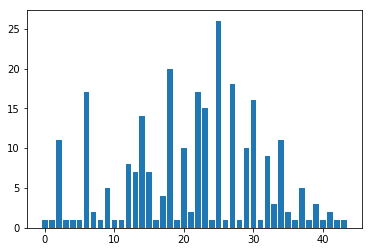

In [143]:
plt.bar(x,count)

In [144]:
for i in range(len(count)):
    print('for: '+str(x[i])+' we have: '+str(count[i]))

for: 0 we have: 1
for: 1 we have: 1
for: 2 we have: 11
for: 3 we have: 1
for: 4 we have: 1
for: 5 we have: 1
for: 6 we have: 17
for: 7 we have: 2
for: 8 we have: 1
for: 9 we have: 5
for: 10 we have: 1
for: 11 we have: 1
for: 12 we have: 8
for: 13 we have: 7
for: 14 we have: 14
for: 15 we have: 7
for: 16 we have: 1
for: 17 we have: 4
for: 18 we have: 20
for: 19 we have: 1
for: 20 we have: 10
for: 21 we have: 2
for: 22 we have: 17
for: 23 we have: 15
for: 24 we have: 1
for: 25 we have: 26
for: 26 we have: 1
for: 27 we have: 18
for: 28 we have: 1
for: 29 we have: 10
for: 30 we have: 16
for: 31 we have: 1
for: 32 we have: 9
for: 33 we have: 3
for: 34 we have: 11
for: 35 we have: 2
for: 36 we have: 1
for: 37 we have: 5
for: 38 we have: 1
for: 39 we have: 3
for: 40 we have: 1
for: 41 we have: 2
for: 42 we have: 1
for: 43 we have: 1
